In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from templates import *

In [4]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [5]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = torch.stack([
    data[0]['img'],
    data[1]['img'],
])

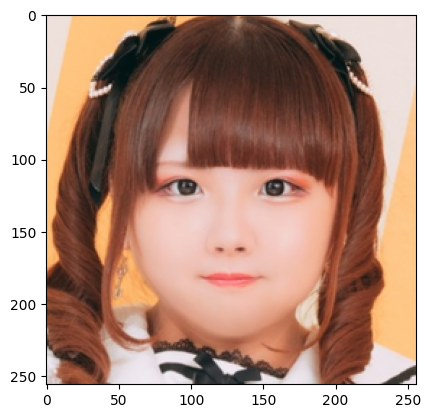

In [6]:
import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)

In [7]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


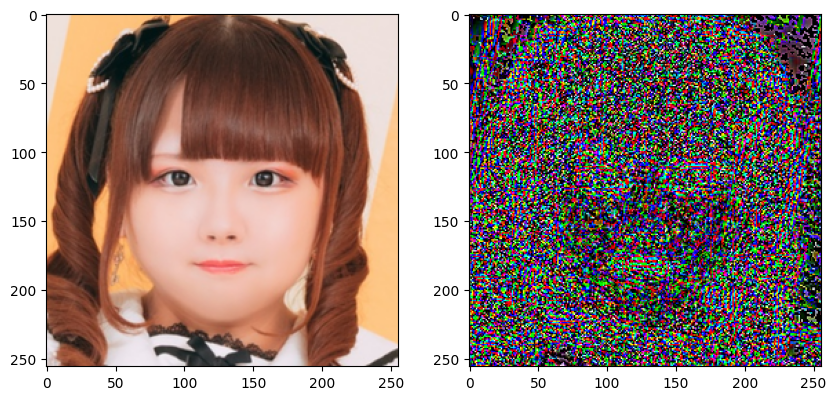

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

# Interpolate

Semantic codes are interpolated using convex combination, while stochastic codes are interpolated using spherical linear interpolation.

In [14]:
import numpy as np
alpha = torch.tensor(np.linspace(0, 1, 10, dtype=np.float32)).to(cond.device)
# alpha[:, None] = alpha.unsqueeze(dim=1)
intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
intp_x = intp_x.view(-1, *x_shape)

pred = model.render(intp_x, intp, T=20)

tensor([[[-7.7129e-01, -2.4146e-01,  5.7008e-01,  ...,  2.1230e-01,
           4.6857e-02, -3.3512e-01],
         [ 5.1262e-01, -4.5695e-01,  4.1304e-01,  ...,  5.1243e-01,
           5.2705e-02, -9.0650e-01],
         [ 3.8027e-01, -4.9146e-01,  3.1502e-01,  ...,  5.6714e-01,
           9.8658e-02, -1.0528e+00],
         ...,
         [-4.3551e-01, -1.9435e-01,  3.3183e-01,  ..., -3.3811e-02,
          -3.8257e-01, -2.2740e-01],
         [-3.5841e-01, -1.7688e+00, -7.8915e-02,  ..., -5.3297e-01,
           6.4960e-01, -2.7902e-01],
         [-8.3894e-01, -8.5243e-01,  7.2294e-01,  ...,  2.4418e-01,
           7.5867e-01,  8.4855e-01]],

        [[-5.9269e-01, -4.0058e-01,  4.2097e-01,  ...,  1.2253e-01,
          -4.9904e-01, -3.4177e-01],
         [ 5.8048e-01, -4.3491e-01,  4.0273e-01,  ...,  4.5087e-01,
          -3.5084e-01,  2.4864e-01],
         [ 3.4611e-01, -6.3618e-01,  1.8932e-01,  ...,  2.3030e-01,
           4.3166e-01,  7.9284e-01],
         ...,
         [ 3.5423e-01,  1

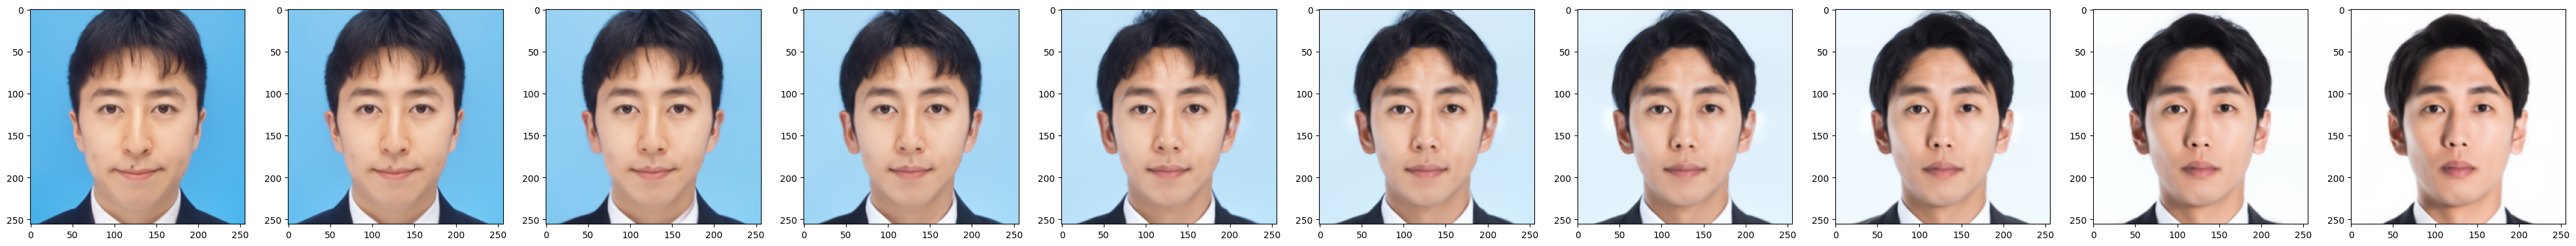

In [17]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 10, figsize=(5*10, 5))
for i in range(len(alpha)):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu())
# plt.savefig('imgs_interpolate/interpolate3.png')